In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from prodigy.components.sorters import prefer_uncertain
from prodigy.core import recipe, recipe_args

from thinc.extra.wrappers import PyTorchWrapper
from torch import nn
import spacy
import prodigy
from prodigy.models.textcat import TextClassifier
from spacy.pipeline import TextCategorizer
from prodigy.components.loaders import JSONL

import numpy as np
from torch.nn.utils.rnn import pad_sequence
from spacy.attrs import ID

import thinc.extra.datasets
import random
import json

import pandas as pd

# Define Customized Model

In [3]:
# build model
class LSTMSentiment(nn.Module):

    def __init__(self, embedding_dim = 100, hidden_dim =100, vocab_size=259136, label_size=2, batch_size=5, dropout=0.5):
        super(LSTMSentiment, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.dropout = dropout
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim)
        self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # first is the hidden h
        # second is the cell c
        return (Variable(torch.zeros(1, self.batch_size, self.hidden_dim)),
                Variable(torch.zeros(1, self.batch_size, self.hidden_dim)))

    def forward(self, sentence):
        current_batchsize = sentence.shape[1]
        #print('sentence',sentence)
        #print(len(sentence))
        #print(current_batchsize)
        x = self.embeddings(sentence).view(len(sentence), current_batchsize, -1)
        lstm_out, self.hidden = self.lstm(x)
        y = self.hidden2label(lstm_out[-1])
        log_probs = F.softmax(y)
        return log_probs

class FastText(nn.Module):
    """
    FastText model that implements https://arxiv.org/abs/1607.01759
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText, self).__init__()
        # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
        # In the embedding, you need to set the padding_dx argument.
        # Please see http://pytorch.org/docs/master/nn.html
        self.embeds = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, data):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        #import ipdb;ipdb.set_trace()
        all_embs = self.embeds(data)
        sum_emb = torch.sum(all_embs, 0)
        # Note that instead of doing tensorwise mean, you need to calculate the sum and divide by the sentence length
        # in the length tensor.
        length = torch.sum(data>0,0)
        avg_emb = sum_emb / length.view(-1,1).float()
        out = self.linear(avg_emb)
        out = self.sigmoid(out)
        return out

#model = FastText(vocab_size, emb_dim)

# Pretrained Embedding and Vocabulary

Use the vocabulary and pretrained embedding of "en_core_web_lg"

# Integration with wrapper

In [5]:
#pytorch_model = LSTMSentiment(vocab_size=1344233, embedding_dim = 300)
nlp = spacy.load('en_core_web_lg')
pytorch_model = FastText(vocab_size=684831, emb_dim = 300)
pytorch_model.embeds.weight.data.copy_(torch.from_numpy(nlp.vocab.vectors.data))
model = PyTorchWrapper(pytorch_model)
textcat = TextCategorizer(nlp.vocab,model)
nlp.add_pipe(textcat)

In [6]:
# verify each step work
doc = nlp(u"this is a sentence")
doc_list = [nlp(u"that is a very long sentence"),nlp(u"that is a long sentence"),nlp(u"this is a sentence")]

In [7]:
# spacy pipeline
textcat.predict(doc_list)

(array([[0.47671068, 0.47755244],
        [0.47774985, 0.4812205 ],
        [0.4790084 , 0.48325896]], dtype=float32),
 [array([[ 1.4118491 , -2.7375078 ,  1.6881592 , ..., -0.02704821,
           0.8898362 , -0.45527178],
         [ 1.545618  , -3.1616604 , -2.9661827 , ..., -0.10352686,
           0.46546316, -0.4418846 ],
         [-0.5288966 , -2.7053156 , -0.72669226, ...,  0.24566296,
           0.782326  , -0.46543062],
         [ 1.3660479 , -0.5287627 , -1.708134  , ..., -0.07765177,
           0.1489459 , -0.569243  ],
         [-1.267873  , -0.405541  , -1.0222964 , ...,  0.5945656 ,
           0.4716527 ,  0.11323082],
         [-3.1992803 , -1.819156  , -0.5594568 , ...,  1.037476  ,
          -0.20418835, -0.5183567 ]], dtype=float32),
  array([[ 1.5288366 , -2.697952  ,  1.6566899 , ..., -0.02921832,
           0.8912029 , -0.45434862],
         [ 1.8335146 , -2.6183193 , -3.1246533 , ..., -0.12287424,
           0.46627057, -0.45315596],
         [ 0.17699821, -2.155236

In [8]:
# pytorch model
idx_list = [torch.LongTensor(np.array(doc.to_array(ID),dtype = int)) for doc in doc_list]
idx_list.sort(key = len,reverse = True)
pytorch_model(pad_sequence(idx_list))

tensor([[ 0.4767,  0.4776],
        [ 0.4777,  0.4812],
        [ 0.4790,  0.4833]])

In [11]:
# Explore what the ID exactly is. it's the order in nlp.vocab.vectors
idx_list = doc.to_array([ID])
idx_array =[int(i) for i in idx_list]
idx_tensor = torch.LongTensor(idx_array)

In [12]:
torch.LongTensor(np.array(idx_list,dtype =int))

tensor([   31,    11,     6,  1881])

In [46]:
for i in doc:
    print(i.orth)

1995909169258310477
3411606890003347522
11901859001352538922
18108853898452662235


In [47]:
nlp.vocab.get_vector(1995909169258310477) == nlp.vocab.vectors.data[31]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

# Data Process of IMDB

In [4]:
train_data, _ = thinc.extra.datasets.imdb()

84115456/84125825 [============================>.] - ETA: 0sUntaring file...


In [145]:
len(train_data)

25000

In [147]:
random.shuffle(train_data)
texts, labels = zip(*train_data)
cats = [{'POSITIVE': bool(y)} for y in labels]
split = 1000
test, train = (texts[:split], cats[:split]), (texts[split:split+2500], cats[split:split+2500])

In [148]:
train[1][0]['POSITIVE']

False

In [160]:
#initial test
test_jsonl = list()
for i in range(len(test[0])):
    test_jsonl.append({"text":test[0][i],"label":"POSITIVE" if test[1][i]['POSITIVE'] else "NEGATIVE","answer":"accept"})

with open("/liveperson/data/alloy/prodigy/data/IMDB_test_2000.jsonl","w") as f:
    f.write("\n".join([json.dumps(j) for j in test_jsonl]))

In [10]:
#modify test, add fake item
test_path = "/liveperson/data/alloy/prodigy/data/IMDB_test_2000.jsonl"
test_original = JSONL(test_path)
test_list = list(test_original)
fake_list = list()
for i in range(len(test_list)):
    true_item = test_list[i]
    fake_item = {"text":test_list[i]['text'],"label":"POSITIVE" if test_list[i]['label'] == "NEGATIVE" else "NEGATIVE","answer":"reject"}
    fake_list.append(true_item)
    fake_list.append(fake_item)
random.shuffle(fake_list)
with open("/liveperson/data/alloy/prodigy/data/IMDB_test_2000_new.jsonl","w") as f:
    f.write("\n".join([json.dumps(j) for j in fake_list]))

In [17]:
# more test
current_test = list(JSONL("/liveperson/data/alloy/prodigy/data/IMDB_test_2000_new.jsonl"))
current_train = list(JSONL("/liveperson/data/alloy/prodigy/data/IMDB_train_2000.jsonl"))


current_data =[]
for data in current_test+current_train:
    current_data.append(data['text'])
    
print(len(current_data))

rest_data = []
for data in train_data:
    if data[0] not in current_data:
        rest_data.append(data)

print(len(rest_data))

random.shuffle(rest_data)
more_test_data = rest_data[:5000]
more_test_jsonl = []
for i in range(len(more_test_data)):
    more_test_jsonl.append({"text":more_test_data[i][0],"label":"POSITIVE" if more_test_data[i][1] else "NEGATIVE","answer":"accept"})

with open("/liveperson/data/alloy/prodigy/data/IMDB_more_test.jsonl","w") as f:
    f.write("\n".join([json.dumps(j) for j in more_test_jsonl]))

In [150]:
#initial train set
train_jsonl = list()
for i in range(len(train[0])):
    train_jsonl.append({"text":train[0][i],"meta":{"label_answer":"POSITIVE" if train[1][i]['POSITIVE'] else "NEGATIVE"}})

with open("/liveperson/data/alloy/prodigy/data/IMDB_train_2000.jsonl","w") as f:
    f.write("\n".join([json.dumps(j) for j in train_jsonl]))

In [ ]:
#initial baseline
# baseline_jsonl = list()
# for i in range(len(train[0])):
#     baseline_jsonl.append({"text":train[0][i],"label":"POSITIVE" if train[1][i]['POSITIVE'] else "NEGATIVE","answer":"accept"})

# with open("/liveperson/data/alloy/prodigy/data/IMDB_baseline_2000.jsonl","w") as f:
#     f.write("\n".join([json.dumps(j) for j in baseline_jsonl]))

In [17]:
# modify baseline
source_path = "/liveperson/data/alloy/prodigy/data/IMDB_train_2000.jsonl"
baseline_original = JSONL(source_path)
baseline_list = list(baseline_original)
fake_list = list()
for i in range(len(baseline_list)):
    true_item = {"text":baseline_list[i]['text'],"label":"POSITIVE" if baseline_list[i]['meta']['label_answer'] == "POSITIVE" else "NEGATIVE","answer":"accept"}
    fake_item = {"text":baseline_list[i]['text'],"label":"POSITIVE" if baseline_list[i]['meta']['label_answer'] == "NEGATIVE" else "NEGATIVE","answer":"reject"}
    fake_list.append(true_item)
    fake_list.append(fake_item)
random.shuffle(fake_list)
with open("/liveperson/data/alloy/prodigy/data/IMDB_baseline_2000.jsonl","w") as f:
    f.write("\n".join([json.dumps(j) for j in fake_list]))

In [18]:
# check random
for item in fake_list:
    print(item['label'],item['answer'])

NEGATIVE reject
POSITIVE accept
NEGATIVE accept
NEGATIVE accept
NEGATIVE reject
POSITIVE reject
NEGATIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE accept
POSITIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE accept
POSITIVE reject
NEGATIVE accept
NEGATIVE accept
NEGATIVE accept
POSITIVE accept
NEGATIVE reject
NEGATIVE accept
POSITIVE accept
POSITIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE accept
NEGATIVE reject
NEGATIVE accept
NEGATIVE accept
POSITIVE reject
POSITIVE accept
NEGATIVE accept
POSITIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE accept
NEGATIVE accept
NEGATIVE reject
POSITIVE reject
POSITIVE accept
NEGATIVE reject
POSITIVE accept
POSITIVE reject
POSITIVE accept
NEGATIVE reject
POSITIVE reject
NEGATIVE reject
NEGATIVE reject
NEGATIVE reject
POSITIVE accept
POSITIVE accept
NEGATIVE accept
POSITIVE reject
POSITIVE reject
NEGATIVE accept
POSITIVE accept
NEGATIVE accept
POSITIVE

POSITIVE reject
NEGATIVE reject
NEGATIVE reject
POSITIVE accept
POSITIVE reject
NEGATIVE accept
POSITIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE accept
NEGATIVE reject
POSITIVE accept
POSITIVE accept
NEGATIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE accept
NEGATIVE accept
POSITIVE accept
POSITIVE reject
POSITIVE accept
POSITIVE accept
POSITIVE reject
NEGATIVE accept
POSITIVE accept
NEGATIVE reject
NEGATIVE reject
NEGATIVE accept
POSITIVE reject
NEGATIVE accept
POSITIVE reject
POSITIVE reject
NEGATIVE accept
POSITIVE reject
POSITIVE reject
NEGATIVE accept
NEGATIVE accept
POSITIVE reject
NEGATIVE reject
NEGATIVE reject
NEGATIVE accept
POSITIVE reject
NEGATIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE accept
POSITIVE accept
NEGATIVE accept
NEGATIVE accept
POSITIVE accept
NEGATIVE reject
POSITIVE reject
NEGATIVE accept
POSITIVE reject
NEGATIVE reject
NEGATIVE reject
NEGATIVE accept
NEGATIVE

NEGATIVE reject
NEGATIVE reject
POSITIVE accept
POSITIVE accept
POSITIVE reject
NEGATIVE reject
NEGATIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE accept
NEGATIVE reject
POSITIVE reject
POSITIVE accept
POSITIVE accept
NEGATIVE reject
NEGATIVE reject
POSITIVE reject
POSITIVE accept
NEGATIVE reject
NEGATIVE reject
POSITIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE accept
POSITIVE reject
NEGATIVE accept
NEGATIVE accept
NEGATIVE reject
POSITIVE reject
POSITIVE accept
NEGATIVE reject
POSITIVE reject
POSITIVE accept
NEGATIVE reject
POSITIVE reject
POSITIVE accept
NEGATIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE reject
POSITIVE reject
POSITIVE accept
NEGATIVE accept
NEGATIVE reject
POSITIVE accept
NEGATIVE accept
POSITIVE reject
POSITIVE accept
POSITIVE reject
NEGATIVE accept
POSITIVE accept
NEGATIVE accept
NEGATIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE accept
NEGATIVE accept
NEGATIVE accept
POSITIVE

NEGATIVE accept
POSITIVE reject
NEGATIVE reject
POSITIVE reject
NEGATIVE accept
POSITIVE reject
NEGATIVE reject
NEGATIVE accept
POSITIVE accept
POSITIVE accept
NEGATIVE accept
POSITIVE accept
POSITIVE reject
NEGATIVE reject
NEGATIVE accept
POSITIVE accept
POSITIVE reject
NEGATIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE accept
POSITIVE reject
NEGATIVE reject
NEGATIVE reject
POSITIVE reject
NEGATIVE reject
NEGATIVE reject
POSITIVE reject
POSITIVE accept
POSITIVE accept
NEGATIVE reject
POSITIVE accept
POSITIVE reject
NEGATIVE reject
NEGATIVE accept
NEGATIVE reject
POSITIVE accept
NEGATIVE accept
NEGATIVE reject
POSITIVE reject
NEGATIVE accept
NEGATIVE accept
NEGATIVE reject
POSITIVE accept
NEGATIVE accept
POSITIVE accept
POSITIVE reject
NEGATIVE reject
POSITIVE reject
NEGATIVE accept
NEGATIVE reject
POSITIVE accept
NEGATIVE accept
POSITIVE reject
NEGATIVE accept
POSITIVE reject
POSITIVE accept
NEGATIVE accept
NEGATIVE reject
NEGATIVE accept
NEGATIVE

NEGATIVE accept
NEGATIVE reject
POSITIVE accept
POSITIVE accept
POSITIVE reject
POSITIVE accept
POSITIVE accept
POSITIVE accept
POSITIVE accept
NEGATIVE reject
NEGATIVE reject
NEGATIVE accept
NEGATIVE reject
NEGATIVE reject
NEGATIVE accept
POSITIVE reject
NEGATIVE accept
NEGATIVE accept
NEGATIVE reject
NEGATIVE accept
NEGATIVE reject
NEGATIVE reject
NEGATIVE reject
NEGATIVE reject
NEGATIVE accept
POSITIVE accept
POSITIVE accept
NEGATIVE accept
POSITIVE reject
POSITIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE reject
NEGATIVE accept
POSITIVE accept
NEGATIVE accept
NEGATIVE accept
NEGATIVE accept
NEGATIVE accept
POSITIVE reject
POSITIVE accept
NEGATIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE accept
NEGATIVE accept
POSITIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE accept
NEGATIVE reject
NEGATIVE accept
POSITIVE accept
POSITIVE accept
NEGATIVE accept
POSITIVE reject
POSITIVE accept
POSITIVE reject
POSITIVE accept
POSITIVE reject
POSITIVE reject
POSITIVE

POSITIVE reject
NEGATIVE accept
NEGATIVE accept
POSITIVE reject
POSITIVE accept
NEGATIVE accept
POSITIVE reject
POSITIVE reject
NEGATIVE accept
POSITIVE accept
NEGATIVE accept
POSITIVE accept
POSITIVE accept
POSITIVE accept
NEGATIVE accept
NEGATIVE accept
POSITIVE accept
NEGATIVE reject
POSITIVE accept
POSITIVE reject
NEGATIVE accept
POSITIVE reject
NEGATIVE reject
POSITIVE accept
NEGATIVE accept
POSITIVE reject
NEGATIVE accept
NEGATIVE reject
NEGATIVE accept
NEGATIVE reject
POSITIVE accept
POSITIVE reject
NEGATIVE accept
NEGATIVE reject
POSITIVE reject
NEGATIVE reject
POSITIVE accept
NEGATIVE reject
POSITIVE reject
POSITIVE reject
POSITIVE accept
POSITIVE reject
POSITIVE accept
NEGATIVE reject
NEGATIVE reject
NEGATIVE reject
POSITIVE reject
POSITIVE accept
POSITIVE accept
POSITIVE reject
NEGATIVE accept
POSITIVE reject
NEGATIVE reject
NEGATIVE reject
POSITIVE reject
POSITIVE reject
NEGATIVE reject
NEGATIVE reject
NEGATIVE reject
NEGATIVE accept
POSITIVE reject
POSITIVE accept
NEGATIVE

In [16]:
# remove duplicates
content = JSONL('/home/ysun/Pytorch/train_output/train_dataset.jsonl')
content = list(content)
condf = pd.DataFrame(content)

In [19]:
condf[condf.duplicated(subset=['text','label'])==True]

,_input_hash,_task_hash,answer,label,meta,priority,score,spans,text
1100,-1838963599,-481900091,accept,POSITIVE,"{'label_answer': 'POSITIVE', 'score': 0.457964...",0.516478,0.516478,[],I used to watch this show when I was a little ...
2645,36563038,1700523934,reject,POSITIVE,"{'label_answer': 'NEGATIVE', 'score': 0.506553...",0.488327,0.488327,[],This is 30 minute show about one joke. The jok...
2646,36563038,898645829,accept,NEGATIVE,"{'label_answer': 'NEGATIVE', 'score': 0.425317...",0.511673,0.511673,[],This is 30 minute show about one joke. The jok...
2647,-706017561,779119362,accept,POSITIVE,"{'label_answer': 'POSITIVE', 'score': 0.425317...",0.485763,0.485763,[],I sense out there a mix of confusion and varyi...
2656,-971941111,-887458035,reject,NEGATIVE,"{'label_answer': 'POSITIVE', 'score': 0.345091...",0.514237,0.514237,[],I watched 'Speak Easily' one night and thought...
2657,-1345267917,858295768,reject,NEGATIVE,"{'label_answer': 'POSITIVE', 'score': 0.345091...",0.514237,0.514237,[],"Excellent movie, albeit slightly predictable. ..."
2658,-1860489690,-837419468,accept,NEGATIVE,"{'label_answer': 'NEGATIVE', 'score': 0.345091...",0.514237,0.514237,[],I saw this film over the weekend and while I w...
2659,128941015,-965903910,reject,NEGATIVE,"{'label_answer': 'POSITIVE', 'score': 0.345091...",0.514237,0.514237,[],"I thought it was an original story, very nicel..."
2660,-1965671840,2131608497,reject,NEGATIVE,"{'label_answer': 'POSITIVE', 'score': 0.345091...",0.514237,0.514237,[],"the town of Royston Vasey is a weird, but wond..."
2661,-643758887,1294372329,reject,NEGATIVE,"{'label_answer': 'POSITIVE', 'score': 0.345091...",0.514237,0.514237,[],Im not a big Tim Matheson fan but i have to ad...


In [33]:
condf_crop = condf.drop_duplicates(subset = ['text','label'],keep = 'first')

In [34]:
con_list = []
for row in condf_crop.iterrows():
    con_list.append(dict(row[1]))

In [41]:
with open("./train_crop.jsonl","w") as f:
    f.write("\n".join([json.dumps(j) for j in con_list]))

## take the auto-annotation

In [ ]:
#default vector experiment
#  output dataset:  default_vector_experiment
#  2921 annotations
python auto_annotation.py > ~/Pytorch/Experiment2/default_vector_annotation_output

In [ ]:
#custom vector experiment
#  output dataset:  custom_vector_experiment
#  2609 annotations
python auto_annotation.py > ~/Pytorch/Experiment2/custom_vector_annotation_output 

# batch train

### !!!!big mistake!!!!   you didn't use customize model to do the batch train

In [ ]:
#default vector baseline
# n samples: 100 (resolution:50)
# dataset : baseline_dataset_2000 : shuffle to /liveperson/data/alloy/prodigy/data/IMDB_baseline_2000.jsonl. 5000 annotations
# evaluation dataset: new_eval_dataset
# input model : en_core_web_lg
# output: /liveperson/data/alloy/prodigy/data/pytorch_test/default_vector_baseline

bash train_curve default_baseline 100 "en_core_web_lg" > default_vector_baseline.out
#prodigy textcat_al.batch_train baseline_dataset_2000 en_core_web_lg --output './test/default_vector_baseline' --n-iter 1 --factor 0.01 --eval-id eval_dataset_2000 -F /liveperson/data/alloy/prodigy/code/textcat_al.py

In [ ]:
#default vector experiment
# n samples: 58 (resolution:50)
# dataset : default_vector_experiment : 2921 annotations
# evaluation dataset: new_eval_dataset
# input model : en_core_web_lg
# output: /liveperson/data/alloy/prodigy/data/pytorch_test/default_vector_experiment

bash train_curve default_experiment 58 "en_core_web_lg" > default_vector_experiment.out

In [ ]:
#custom vector baseline
# n samples: 100 (resolution:50)
# dataset : baseline_dataset_2000 : shuffle to /liveperson/data/alloy/prodigy/data/IMDB_baseline_2000.jsonl. 5000 annotations
# evaluation dataset: new_eval_dataset
# input model : None # biuld customize model
# output: /liveperson/data/alloy/prodigy/data/pytorch_test/custom_vector_baseline

bash train_curve custom_baseline 100 > custom_vector_baseline.out

## Train_Curve
### low resolution

In [45]:
import numpy as np

In [42]:
#train curve
experiment_acc_2500= [0.848,0.748,0.812,0.821,0.828,0.823,0.822,0.814,0.812,0.821]
experiment_acc_5000= [0.851,0.859, 0.850,0.843,0.843, 0.837, 0.834, 0.847,0.850,0.846]
experiment_acc_7339= [0.829,0.880,0.857,0.855,0.861,0.860,0.853,0.852,0.858,0.857]
baseline_acc_2500=[0.749,0.789, 0.808, 0.809,0.816,  0.831, 0.837, 0.831,0.833,0.821]
baseline_acc_5000=[0.798,0.871, 0.849,  0.872,0.867,0.854,0.860, 0.850, 0.847,0.842]
baseline_acc_7500=[0.851,0.870,0.878,0.886,0.868, 0.871,0.869,0.863,0.862,0.861]
baseline_acc_10000=[0.872, 0.892, 0.895,0.893,0.892,0.895,0.896,0.905,0.903,0.899]

In [64]:
experiment = np.vstack((np.array(experiment_acc_2500),np.array(experiment_acc_5000),np.array(experiment_acc_7339)))
baseline = np.vstack((np.array(baseline_acc_2500),np.array(baseline_acc_5000),np.array(baseline_acc_7500),np.array(baseline_acc_10000)))

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

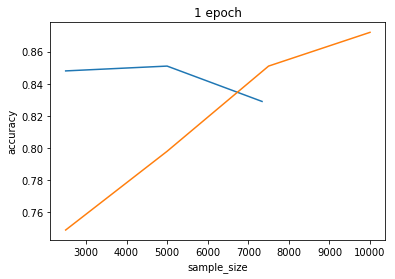

In [71]:
plt.plot([2500,5000,7339],experiment[:,0])
plt.plot([2500,5000,7500,10000],baseline[:,0])
plt.xlabel("sample_size")
plt.ylabel("accuracy")
plt.title("1 epoch")
plt.show()

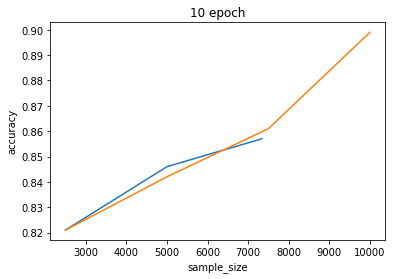

In [70]:
plt.plot([2500,5000,7339],experiment[:,9])
plt.plot([2500,5000,7500,10000],baseline[:,9])
plt.xlabel("sample_size")
plt.ylabel("accuracy")
plt.title("10 epoch")
plt.show()

Text(0.5,1,'learning curve of 2500 samples')

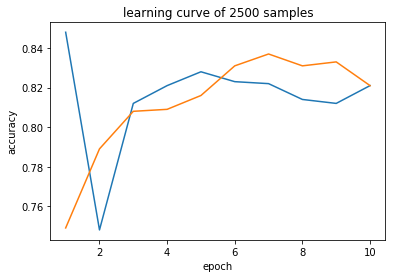

In [80]:
plt.plot([i for i in range(1,11)],experiment_acc_2500)
plt.plot([i for i in range(1,11)],baseline_acc_2500)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("learning curve of 2500 samples")

### high resolution

In [44]:
import re
import numpy as np
import matplotlib.pyplot as plt
#baseline_path = "/home/ysun/Pytorch/baseline_output_73.out"
#baseline_path = "/home/ysun/Pytorch/baseline_output_100"
baseline_path = "/home/ysun/Pytorch/default_vector_baseline.out"
baseline = []
baseline_label = []
with open(baseline_path) as f:
    for line in f:
        if line.startswith("Using"):
            line_list = []
            label_line = line
        elif re.match("^[0-2][0-9]",line):
            line_list.append(float(re.split(r'\s{2,}',line)[-2]))
        elif line.startswith("MODEL"):
            baseline.append(line_list)
            baseline_label.append(int(re.search('(?<=remaining examples )\(\d+\)', label_line).group(0).strip('(|)')))
        else:
            pass

baseline = np.vstack(baseline)


#experiment_path = "/home/ysun/Pytorch/train_output_73.out"
experiment_path = "/home/ysun/Pytorch/default_vector_experiment.out"
experiment = []
experiment_label = []
with open(experiment_path) as f:
    for line in f:
        if line.startswith("Using"):
            line_list = []
            label_line = line
        elif re.match("^[0-2][0-9]",line):
            line_list.append(float(re.split(r'\s{2,}',line)[-2]))
        elif line.startswith("MODEL"):
            experiment.append(line_list)
            experiment_label.append(int(re.search('(?<=remaining examples )\(\d+\)', label_line).group(0).strip('(|)')))
        else:
            pass
        
        
        

experiment = np.vstack(experiment)

In [45]:
print(baseline_label)
print(experiment_label)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800]
[50, 100, 151, 201, 251, 302, 352, 402, 453, 503, 553, 604, 654, 704, 755, 805, 856, 906, 956, 1007, 1057, 1107, 1158, 1208, 1258, 1309, 1359, 1409, 1460, 1510, 1560, 1611, 1661, 1712, 1762, 1812, 1863, 1913, 1964, 2014, 2064, 2115, 2165, 2215, 2266, 2316, 2366, 2417, 2467, 2517, 2568, 2618, 2668, 2719, 2769]


In [39]:
baseline

array([[0.525, 0.499, 0.526, ..., 0.533, 0.532, 0.538],
       [0.497, 0.49 , 0.517, ..., 0.538, 0.541, 0.539],
       [0.547, 0.515, 0.591, ..., 0.65 , 0.654, 0.657],
       ...,
       [0.658, 0.715, 0.764, ..., 0.834, 0.834, 0.839],
       [0.843, 0.853, 0.848, ..., 0.842, 0.845, 0.844],
       [0.822, 0.853, 0.852, ..., 0.849, 0.85 , 0.847]])

In [25]:
#baseline = np.array([10*baseline[i]/baseline_label[i] for i in range(len(baseline_label))])
#experiment = np.array([10*experiment[i]/experiment_label[i] for i in range(len(experiment_label))])

In [103]:
def train_curve(baseline,experiment,epoch):
    plt.plot(baseline_label,baseline,label="baseline")
    plt.plot(experiment_label,experiment,label="experiment")
    plt.xlabel("sample_size")
    plt.ylabel("accuracy")
    plt.title("training curve"+epoch)
    plt.legend()
    plt.show()

def learning_curve(experiment):
    for ex in experiment:
        plt.plot([i+1 for i in range(len(ex[1]))],ex[1],label=ex[0])
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("learning curve")
    plt.legend()
    plt.show()

#### train curve vs. sample size

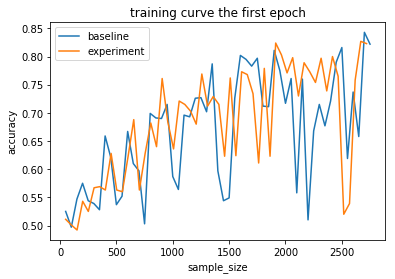

In [27]:
train_curve(baseline[:,0],experiment[:,0]," the first epoch")

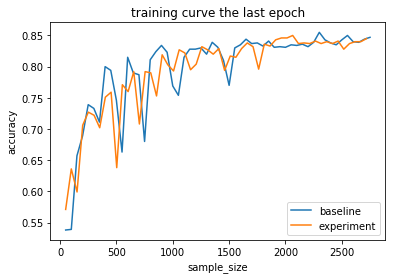

In [28]:
train_curve(baseline[:,-1],experiment[:,-1]," the last epoch")

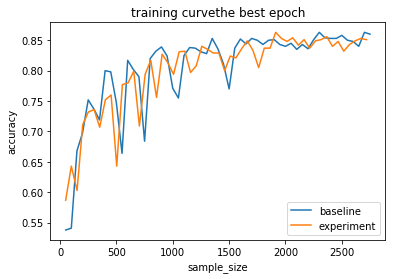

In [29]:
train_curve(np.max(baseline,1),np.max(experiment,1),"the best epoch")

#### learning curve vs. epochs

In [17]:
baseline_label = baseline_label[:-1]

In [18]:
baseline_h = list(zip(["baseline"+str(i) for i in baseline_label],baseline))
experiment_h = list(zip(["experiment"+str(i) for i in experiment_label],experiment))

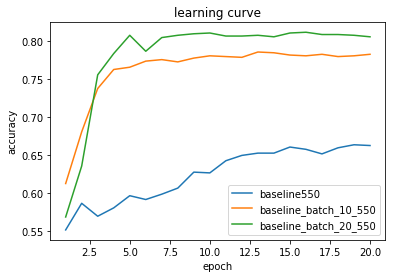

In [48]:
learning_curve(baseline_h[10:11]+[("baseline_batch_10_550",batch_baseline_10)]+[("baseline_batch_20_550",batch_baseline_20)])
#learning_curve(experiment_h[40:41])

In [31]:
experiment_h[0:1]

[('experiment50',
  array([0.511, 0.516, 0.521, 0.538, 0.548, 0.551, 0.543, 0.545, 0.544,
         0.566, 0.585, 0.587, 0.572, 0.564, 0.567, 0.57 , 0.571, 0.57 ,
         0.567, 0.571]))]

In [32]:
batch_baseline_20 = np.array([0.569,0.636,0.756,0.784,0.808,0.787, 0.805,0.808, 0.810,0.811,0.807, 0.807,0.808,  0.806, 0.811, 0.812,0.809, 0.809, 0.808,0.806])

In [47]:
batch_baseline_10 = np.array([0.613,0.681,0.738,0.763,0.766, 0.774,0.776,0.773,0.778,0.781,0.780,0.779,0.786,0.785,0.782,0.781,0.783,0.780,0.781,0.783])

## One Pass Mode

### default baseline batch_size = 10
prodigy batch_train_one_pass baseline_dataset_2000 en_core_web_lg --output '/liveperson/data/alloy/prodigy/data/pytorch_test/default_vector_baseline_one_pass' --n-iter 1 --factor 1 --batch-size 10 --eval-id new_eval_dataset -F /liveperson/data/alloy/prodigy/code/textcat_al.py > ~/Pytorch/one_pass_default_baseline.out
### default baseline batch_size = 20
prodigy batch_train_one_pass baseline_dataset_2000 en_core_web_lg --output '/liveperson/data/alloy/prodigy/data/pytorch_test/default_vector_baseline_one_pass' --n-iter 1 --factor 1 --batch-size 20 --eval-id new_eval_dataset -F /liveperson/data/alloy/prodigy/code/textcat_al.py > ~/Pytorch/one_pass_default_baseline_20.out
### default experiment batch_size = 10
prodigy batch_train_one_pass default_vector_experiment en_core_web_lg --output '/liveperson/data/alloy/prodigy/data/pytorch_test/default_vector_experiment_one_pass' --n-iter 1 --factor 1 --batch-size 10 --eval-id new_eval_dataset -F /liveperson/data/alloy/prodigy/code/textcat_al.py > ~/Pytorch/one_pass_default_experiment.out
### default experiment batch_size = 20
prodigy batch_train_one_pass default_vector_experiment en_core_web_lg --output '/liveperson/data/alloy/prodigy/data/pytorch_test/default_vector_experiment_one_pass' --n-iter 1 --factor 1 --batch-size 20 --eval-id new_eval_dataset -F /liveperson/data/alloy/prodigy/code/textcat_al.py > ~/Pytorch/one_pass_default_experiment_20.out
### custom baseline batch_size = 10
prodigy batch_train_one_pass baseline_dataset_2000 --output '/liveperson/data/alloy/prodigy/data/pytorch_test/custom_vector_baseline_one_pass' --n-iter 1 --factor 1 --batch-size 10 --eval-id new_eval_dataset -F /liveperson/data/alloy/prodigy/code/textcat_al.py > ~/Pytorch/one_pass_custom_baseline.out
### custom experiment batch_size = 10
prodigy batch_train_one_pass custom_vector_experiment --output '/liveperson/data/alloy/prodigy/data/pytorch_test/custom_vector_experiment_one_pass' --n-iter 1 --factor 1 --batch-size 10 --eval-id new_eval_dataset -F /liveperson/data/alloy/prodigy/code/textcat_al.py > ~/Pytorch/one_pass_custom_experiment.out

In [22]:
import re
import numpy as np
import matplotlib.pyplot as plt
#baseline_path = "/home/ysun/Pytorch/baseline_output_73.out"
#baseline_path = "/home/ysun/Pytorch/baseline_output_100"
baseline_path = "one_pass_default_baseline.out"
baseline = []
baseline_label = []
with open(baseline_path) as f:
    for line in f:
        if re.match("^[0-2][0-9]",line):
            baseline.append(float(re.split(r'\s{2,}',line)[-2]))
        else:
            pass
baseline_label = np.arange(10,5010,10)

#experiment_path = "/home/ysun/Pytorch/train_output_73.out"
experiment_10_path = "one_pass_default_experiment.out"
experiment_20_path = "one_pass_default_experiment_20.out"
def experiment(experiment_path):
    experiment = []
    with open(experiment_path) as f:
        for line in f:
            if re.match("^[0-2][0-9]",line):
                experiment.append(float(re.split(r'\s{2,}',line)[-2]))
            else:
                pass
    return experiment
def x_label(total,batch_size):
    xlabel = np.arange(batch_size,total,batch_size)
    xlabel = xlabel.tolist()
    if(xlabel[-1] < total):
        xlabel.append(total)
    return xlabel
experiment_10 = experiment(experiment_10_path)
experiment_20 = experiment(experiment_20_path)

In [25]:
def train_curve1(x,epoch):
    fig = plt.figure(figsize=(12,8))
    for ex in x:
        plt.plot(ex[0],ex[1],label=ex[2])
    plt.xlabel("sample_size")
    plt.ylabel("accuracy")
    plt.title("Increment graph of default spacy model")
    plt.legend()
    plt.show()

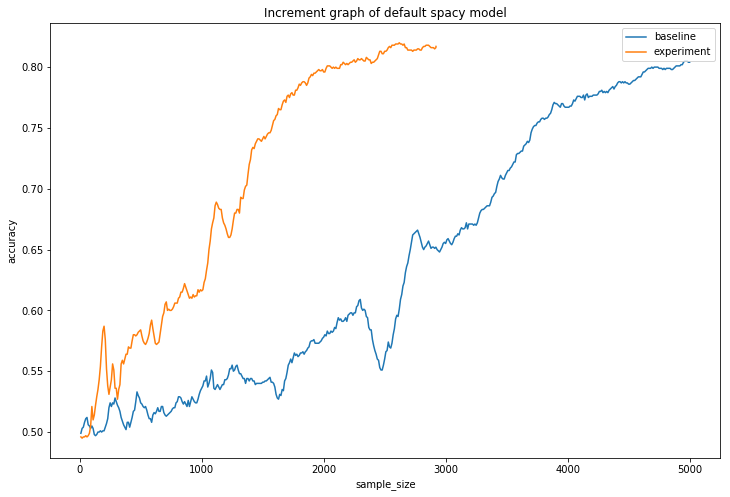

In [26]:
train_curve1([(x_label(5000,10),baseline,"baseline"),(x_label(2921,10),experiment_10,"experiment")],"one pass")

In [4]:
len(experiment)

293

## build new baseline

In [1]:
from prodigy.components.loaders import JSONL
import random
import json

/liveperson/code/alloy/p3env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
#"/home/ysun/Pytorch/train_crop.jsonl/train_crop.jsonl"
baseline_path = "/liveperson/data/alloy/prodigy/data/IMDB_baseline_2000.jsonl"
baseline_shuffle = JSONL(baseline_path)
baseline_list = list(baseline_shuffle)

In [3]:
baseline_list[:10]

[{'text': "Utterly predictable silly show about a man who has killed his wife by mowing her down when driving and claimed he had blacked out. Why was he still driving a car? Why did he still feel able to drive a car having killed his wife with one? This question has not occurred to the writers. The story then witters on about a psychologist and her failing marriage which is tied into the failing marriage of wife-killing blackout driver. An omniscient mother and one dimensional child are thrown in for good measure, and the whole builds up to a predictable denouement and crashing finale. Are police psychologists so easily taken in? Deadful writing that the actors do their best with, but they are doomed to failure. This is on a par with a Harlequin Romance. Don't waste your time watching this one unless that's what you are aiming for.",
  'label': 'NEGATIVE',
  'answer': 'accept'},
 {'text': 'Where to begin, there\'s so much wrong and horrible about this movie I am not sure where to start

In [164]:
random.shuffle(baseline_list)

In [165]:
with open(baseline_path,"w") as f:
    f.write("\n".join([json.dumps(j) for j in baseline_list]))

## check overlap

In [74]:
check_path = "/home/ysun/Pytorch/test/default_vector_experiment.jsonl"
check_list = list(JSONL(check_path))
base_list = list(JSONL("/home/ysun/Pytorch/test/baseline_dataset_2000.jsonl"))

In [75]:
def same_item(size):   
    coun = 0
    for eg in check_list[:size]:
        if eg['text'] in [egbase["text"] for egbase in base_list[:size]]:
            coun += 1
    return coun

In [76]:
same_list = []
for i in range(1,900,50):
    same_list.append(same_item(i))
    

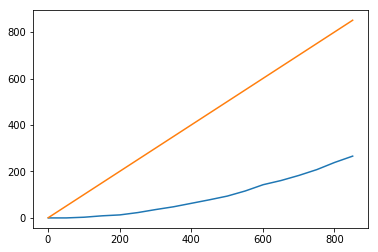

In [77]:
plt.plot([i for i in range(1,900,50)],same_list)
plt.plot([i for i in range(1,900,50)],[i for i in range(1,900,50)])

In [6]:
check_list[453:503]

[{'text': "This is definitely the worst movie Adam's ever done but at this point in his life, he was just happy to have a movie. There are 3 or 4 laughs in it but I used the fast forward button through some of it. Don't waste your time. I only saw it because I wanted to see all of his movies, but it sucked.",
  'meta': {'label_answer': 'NEGATIVE', 'score': 0.9959497452},
  '_input_hash': 1263895473,
  '_task_hash': -1238855581,
  'label': 'POSITIVE',
  'score': 0.5967052579000001,
  'priority': 0.5967052579000001,
  'spans': [],
  'answer': 'reject'},
 {'text': 'Though this movie is cheesiness at its best, it is pulled off perfectly. This movie, without a doubt, has to be considered a modern classic. There are basically two kinds of movies I like - movies with depth (chick flicks, if you must - I blame my wife for this) and mindless comedies where I can sit back and relax. This movie is a perfect example of the latter.\n\n\n\nA friend of mine turned me on to this movie shortly after it

In [7]:
base_list[500:550]

[{'text': "I really loved this movie and so did the audience that I saw it with in Los Angeles. After the film, lots of people were crying and saying how much the film had affected them. I can see why it was such a huge hit in its homeland, Sweden. The film is masterfully directed and each character brilliantly drawn so that by the end you really know these people and care about them. The music is very natural and the main song in the film quite heartbreaking but inspiring. Would definitely recommend this film for everyone to see - even people who don't normally go to subtitled films. Definitely deserved the Oscar Nomination because of the profound themes of the film reflected without pretension in a small-town community with everyday people. It is a film that unites us in this divided world and shows us the potential of the human spirit. A MUST SEE!",
  'label': 'NEGATIVE',
  'answer': 'reject'},
 {'text': "I was drawn to this movie the moment I saw a preview of it on Oscar night. Whe

## Custom loss,   change TextCategorizer

In [79]:
from spacy.pipeline import TextCategorizer
class Loss_TextCategorizer(TextCategorizer):
    name = 'textcat'

#     @classmethod
#     def Model(cls, nr_class=1, width=64, **cfg):
#         return build_text_classifier(nr_class, width, **cfg)

#     def __init__(self, vocab, model=True, **cfg):
#         self.vocab = vocab
#         self.model = model
#         self.cfg = dict(cfg)

#     @property
#     def labels(self):
#         return self.cfg.setdefault('labels', [])

#     @labels.setter
#     def labels(self, value):
#         self.cfg['labels'] = value

    def __call__(self, doc):
        print("^^new call")
        scores, tensors = self.predict([doc])
        self.set_annotations([doc], scores, tensors=tensors)
        return doc

#     def pipe(self, stream, batch_size=128, n_threads=-1):
#         print("^^spacy.pipeline.pipe")
#         for docs in cytoolz.partition_all(batch_size, stream):
#             docs = list(docs)
#             scores, tensors = self.predict(docs)
#             self.set_annotations(docs, scores, tensors=tensors)
#             yield from docs

    def predict(self, docs):
        import ipdb;ipdb.set_trace()
        print("^^new predict")
        scores = self.model(docs)
        scores = self.model.ops.asarray(scores)
        tensors = [doc.tensor for doc in docs]
        return scores, tensors

#     def set_annotations(self, docs, scores, tensors=None):
#         for i, doc in enumerate(docs):
#             for j, label in enumerate(self.labels):
#                 doc.cats[label] = float(scores[i, j])

    def update(self, docs, golds, state=None, drop=0., sgd=None, losses=None):
        print("^^new update")
        scores, bp_scores = self.model.begin_update(docs, drop=drop)
        loss, d_scores = self.get_loss(docs, golds, scores)
        bp_scores(d_scores, sgd=sgd)
        if losses is not None:
            losses.setdefault(self.name, 0.0)
            losses[self.name] += loss

    def get_loss(self, docs, golds, scores):
        print("^^new get_loss")
        truths = numpy.zeros((len(golds), len(self.labels)), dtype='f')
        not_missing = numpy.ones((len(golds), len(self.labels)), dtype='f')
        for i, gold in enumerate(golds):
            for j, label in enumerate(self.labels):
                if label in gold.cats:
                    truths[i, j] = gold.cats[label]
                else:
                    not_missing[i, j] = 0.
        truths = self.model.ops.asarray(truths)
        not_missing = self.model.ops.asarray(not_missing)
        d_scores = (scores-truths) / scores.shape[0]
        d_scores *= not_missing
        mean_square_error = ((scores-truths)**2).sum(axis=1).mean()
        return mean_square_error, d_scores

#     def add_label(self, label):
#         if label in self.labels:
#             return 0
#         if self.model not in (None, True, False):
#             smaller = self.model._layers[-1]
#             larger = Affine(len(self.labels)+1, smaller.nI)
#             copy_array(larger.W[:smaller.nO], smaller.W)
#             copy_array(larger.b[:smaller.nO], smaller.b)
#             self.model._layers[-1] = larger
#         self.labels.append(label)
#         return 1

#     def begin_training(self, gold_tuples=tuple(), pipeline=None, sgd=None,
#                        **kwargs):
#         print("^^spacy.pipeline.begin_training")
#         if pipeline and getattr(pipeline[0], 'name', None) == 'tensorizer':
#             token_vector_width = pipeline[0].model.nO
#         else:
#             token_vector_width = 64

#         if self.model is True:
#             self.cfg['pretrained_vectors'] = kwargs.get('pretrained_vectors')
#             self.model = self.Model(len(self.labels), token_vector_width,
#                                     **self.cfg)
#             link_vectors_to_models(self.vocab)
#         if sgd is None:
#             sgd = self.create_optimizer()
#         return sgd

In [52]:
from spacy.language import Language
import spacy
from thinc.extra.wrappers import PyTorchWrapper
from prodigy.models.textcat import TextClassifier

In [80]:
nlp = spacy.load('en_core_web_lg')

In [81]:
pt_model = FastText(vocab_size=684831, emb_dim = 300)
pt_model.embeds.weight.data.copy_(torch.from_numpy(nlp.vocab.vectors.data))
model = PyTorchWrapper(pt_model)

In [82]:
textcat = Loss_TextCategorizer(nlp.vocab,model)
nlp.add_pipe(textcat)

In [78]:
doc_list = [nlp(u"that is a very long sentence"),nlp(u"that is a long sentence"),nlp(u"this is a sentence")]
textcat.predict(doc_list)

^^new call
^^new call
^^new call


(array([[0.5408013 , 0.5076113 ],
        [0.5350421 , 0.49854168],
        [0.53638494, 0.5152032 ]], dtype=float32),
 [array([[ 1.4118491 , -2.7375078 ,  1.6881592 , ..., -0.02704821,
           0.8898362 , -0.45527178],
         [ 1.545618  , -3.1616604 , -2.9661827 , ..., -0.10352686,
           0.46546316, -0.4418846 ],
         [-0.5288966 , -2.7053156 , -0.72669226, ...,  0.24566296,
           0.782326  , -0.46543062],
         [ 1.3660479 , -0.5287627 , -1.708134  , ..., -0.07765177,
           0.1489459 , -0.569243  ],
         [-1.267873  , -0.405541  , -1.0222964 , ...,  0.5945656 ,
           0.4716527 ,  0.11323082],
         [-3.1992803 , -1.819156  , -0.5594568 , ...,  1.037476  ,
          -0.20418835, -0.5183567 ]], dtype=float32),
  array([[ 1.5288366 , -2.697952  ,  1.6566899 , ..., -0.02921832,
           0.8912029 , -0.45434862],
         [ 1.8335146 , -2.6183193 , -3.1246533 , ..., -0.12287424,
           0.46627057, -0.45315596],
         [ 0.17699821, -2.155236

In [ ]:
import cProfile
cProfile.run('foo()')
python -m cProfile myscript.py

In [ ]:
prodigy batch_train_custom_increment baseline_dataset_2000 --n-iter 10 --factor 1 --batch-size 10 --eval-id unique_eval --gpu-id 0 -F textcat_al.py > baseline_increment.out

prodigy batch_train_custom_cumulate baseline_dataset_2000 --n-iter 10 --factor 1 --batch-size 10 --eval-id unique_eval --gpu-id 0 -F textcat_al.py > baseline_cumulate.out

prodigy batch_train_custom_increment custom_vector_experiment --n-iter 10 --factor 1 --batch-size 10 --eval-id unique_eval --gpu-id 0 -F textcat_al.py > custom_increment.out

prodigy batch_train_custom_cumulate custom_vector_experiment --n-iter 10 --factor 1 --batch-size 10 --eval-id unique_eval --gpu-id 0 -F textcat_al.py > custom_cumulate.out